In [9]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
def compute_loss_mse(y, tx, w):
    """ COMPUTE_LOSS_MSE
        Calculates the loss of a dataset using MSE.

        INPUTS:
        y: an Nx1 array of the output variable
        tx: an Nxd array of the input variable
        w: a dx1 array of the model

        OUTPUTS:
        A scalar of the mean square error of the model applied on the dataset
    """
    return sum((y - tx @ w)**2)/len(y)

def compute_loss_rmse(y, tx, w):
    """ COMPUTE_LOSS_RMSE
        Calculates the loss of a dataset using RMSE.

        INPUTS:
        y: an Nx1 array of the output variable
        tx: an Nxd array of the input variable
        w: a dx1 array of the model

        OUTPUTS:
        A scalar of the mean square error of the model applied on the dataset
    """
    return np.sqrt(compute_loss_mse(y,tx,w))

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [76]:
def least_squares(y, tx):
    """ LEAST_SQUARES Calculates the least squares solution
        Calculates the least squares solution to a given dataset
        Returns the mean square error and optimal weights
        
        INPUTS
        y (Nx1): array of the output data with N datapoints
        tx (NxD): array of the input data with N datapoints and D characteristics
        
        OUTPUTS
        MSE: A scalar of the mean square error of the model
        w: the optimal weights for the given system
    """
    w = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    MSE = compute_loss_mse(y, tx, w)
    return MSE, w

def calc_rmse(y, tx):
    """ RMSE Calculates the root mean square error
        Calculates the least squares solution to a given dataset
        Returns the root mean square and optimal weights
        
        INPUTS
        y (Nx1): array of the output data with N datapoints
        tx (NxD): array of the input data with N datapoints and D characteristics
        
        OUTPUTS
        MSE: A scalar of the mean square error of the model
        w: the optimal weights for the given system
    """
    [MSE, w] = least_squares(y, tx)
    return np.sqrt(MSE), w

In [12]:
def generate_w(num_intervals):
    """Generate a grid of values for w0 and w1."""
    w0 = np.linspace(-100, 200, num_intervals)
    w1 = np.linspace(-150, 150, num_intervals)
    return w0, w1


def get_best_parameters(w0, w1, losses):
    """Get the best w from the result of grid search."""
    min_row, min_col = np.unravel_index(np.argmin(losses), losses.shape)
    return losses[min_row, min_col], w0[min_row], w1[min_col]

def grid_search(y, tx, w0, w1):
    """ GRID_SEARCH
        Performs a naive grid search of parameters w0 and w1 as a model
        for the output variable y

        INPUTS:
        y: an Nx1 array of the output variable
        tx: an Nxd array of the input variable
        w0: An m-dimensional array of the first elements (offset) of the model
        w1: An n-dimensional array of the second elements of the model

        OUTPUTS:
        An m by n array of the costs for each of the combinations of w0 and w1
    """
    losses = np.zeros((len(w0), len(w1)))

    for i in range(0,len(w0)):
        for j in range(0,len(w1)):
            losses[i,j] = compute_loss_mse(y, tx, np.array([w0[i],w1[j]]).T)
    return losses

In [13]:
def compute_gradient_mse(y, tx, w):
    """ COMPUTE_GRADIENT
        Computes the gradient of the MSE of a model applied on a set

        INPUTS:
        y: an Nx1 array of the output variable
        tx: an Nxd array of the input variable
        w: a dx1 array of the model

        OUTPUTS:
        A dx1 array of the gradient 
    """
    return -1/len(y) * tx.T @ (y - tx @ w)

def gradient_descent_mse(y, tx, initial_w, max_iters, gamma):
    """ GRADIENT_DESCENT
        Iterates and finds the best model using gradient descent and MSE

        INPUTS:
        y: an Nx1 array of the output variable
        tx: an Nxd array of the input variable
        initial_w: a dx1 array of the initial model to use
        max_iters: a scalar representing the maximum number of iterations
        gamma: a scalar representing the step size/learning rate

        OUTPUTS:
        losses: a max_iters dimensional array representing losses for iterations
        ws: a max_iters dimensional array representing models over iterations
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute the gradient and loss given the current w
        grad = compute_gradient_mse(y, tx, w)
        loss = compute_loss_mse(y, tx, w)
        # update w by gradient descent
        w = w - gamma*grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [30]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    # *****************gridsearch************************
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=10)
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    # Select the best combinaison
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    
    
    # *****************gradient descent************************
        # Define the parameters of the algorithm.
    max_iters = 50
    gamma = 0.7

    # Initialization
    w_initial = np.array([0,0])

    # Start gradient descent.
    gradient_losses, gradient_ws = gradient_descent_mse(y, tx, w_initial, max_iters, gamma)
    
    # ****************least squares**********************
    MSE, w = least_squares(y, tx)
    
    
    print("\nGrid search: loss={l}, w0={w0}, w1={w1}".format(
          l=loss_star, w0=w0_star, w1=w1_star))
    print("Gradient descent: loss={l}, w0={w0}, w1={w1}".format(
          l=gradient_losses[-1], w0=gradient_ws[-1][0], w1=gradient_ws[-1][1]))
    print("Least squares: loss={l}, w0={w0}, w1={w1}".format(
          l=MSE, w0=w[0], w1=w[1]))

Test it here

In [29]:
test_your_least_squares()

Gradient Descent(0/49): loss=5584.473425518329, w0=51.30574540147363, w1=9.435798704492242
Gradient Descent(1/49): loss=530.6049242179228, w0=66.69746902191571, w1=12.266538315839977
Gradient Descent(2/49): loss=75.75675910088263, w0=71.31498610804834, w1=13.115760199244315
Gradient Descent(3/49): loss=34.820424240348956, w0=72.70024123388814, w1=13.370526764265625
Gradient Descent(4/49): loss=31.136154102900903, w0=73.11581777164007, w1=13.446956733772021
Gradient Descent(5/49): loss=30.804569790530707, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=30.77472720241716, w0=73.27789262136334, w1=13.476764421879517
Gradient Descent(7/49): loss=30.772041369486978, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=30.771799644523412, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=30.771777889276482, w0=73.29348920882515, w1=13.47963283863509
Gradient Descent(10/49): loss=30.771775931304305, w0=73.29379216412117, w1=13

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [26]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [102]:
def build_poly(x, degree):
    """ BUILD_POLY Polynomial basis functions for input data x, for j=0 up to j=degree
        Takes an input vector x and returns a polynomial basis of degree j=degree

        INPUTS:
        x (N x 1): an array of the output variable with only 1 feature
        degree: The highest degree of the basis

        OUTPUTS:
        basis (N x degree): a polynomial basis on the output variable
    """
    x_expanded = np.tile(x,[degree+1,1]).T #expands the variable to degree of basis
    powers = np.tile(np.arange(0,degree+1), [len(x),1]) #create the array of powers to raise
    basis = np.power(x_expanded, powers)
    
    return basis
    
    

In [70]:
print(x.shape)
b = np.tile(x,[4,1]).T
a = np.arange(0,4)
a = np.tile(a, [50,1])
print(b)
print(np.power(b,a))
print(build_poly(x,3))

(50,)
[[0.35237491 0.35237491 0.35237491 0.35237491]
 [4.8951233  4.8951233  4.8951233  4.8951233 ]
 [1.86662437 1.86662437 1.86662437 1.86662437]
 [3.50706129 3.50706129 3.50706129 3.50706129]
 [3.38087384 3.38087384 3.38087384 3.38087384]
 [0.73093728 0.73093728 0.73093728 0.73093728]
 [3.88562366 3.88562366 3.88562366 3.88562366]
 [5.65224803 5.65224803 5.65224803 5.65224803]
 [6.28318531 6.28318531 6.28318531 6.28318531]
 [2.37137419 2.37137419 2.37137419 2.37137419]
 [0.60474982 0.60474982 0.60474982 0.60474982]
 [3.63324875 3.63324875 3.63324875 3.63324875]
 [0.85712473 0.85712473 0.85712473 0.85712473]
 [2.49756165 2.49756165 2.49756165 2.49756165]
 [1.61424946 1.61424946 1.61424946 1.61424946]
 [5.39987312 5.39987312 5.39987312 5.39987312]
 [6.15699785 6.15699785 6.15699785 6.15699785]
 [6.0308104  6.0308104  6.0308104  6.0308104 ]
 [0.47856237 0.47856237 0.47856237 0.47856237]
 [2.87612401 2.87612401 2.87612401 2.87612401]
 [4.51656093 4.51656093 4.51656093 4.51656093]
 [0.983

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [109]:
from plots import *

def polynomial_regression(x, y):
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        poly_basis = build_poly(x, degree)
        rmse, weights = calc_rmse(y,poly_basis)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.24965870360907527
Processing 4th experiment, degree=12, rmse=0.9268294526468843


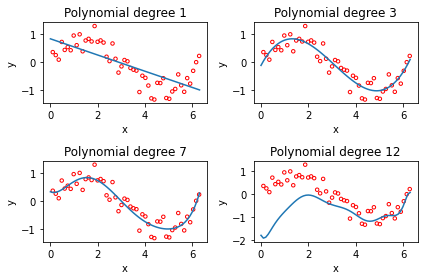

In [110]:
polynomial_regression(x, y)

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [128]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    shuffled_indices = np.argsort(np.random.rand(len(x))) # array of random indices to shuffle data
    x = x[shuffled_indices] # reorder the array
    y = y[shuffled_indices] # reorder the array
    
     # finds where to cutoff. int() will round down, if dataset large enough not important if round up/down
    cutoff = int(len(x) * ratio)
    
    # split the arrays according to the ratio
    x1 = x[0:cutoff]
    y1 = y[0:cutoff]
    x2 = x[cutoff+1:]
    y2 = y[cutoff+1:]
    
    return x1, y1, x2, y2

In [126]:
np.random.seed(1)
np.random.rand()
a = np.random.rand(x.shape[0])
a = x[np.argsort(a)]
ratio = 0.23
b = int(len(a) * ratio)
a[0:b]

array([4.8951233 , 5.27368567, 5.14749821, 2.49756165, 4.01181111,
       1.36187455, 3.38087384, 1.2356871 , 1.74043692, 2.74993656,
       6.0308104 ])

Then, test your `split_data` function below.

In [145]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    train_x, train_y, test_x, test_y = split_data(x,y,ratio)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    train_poly = build_poly(train_x, degree)
    test_poly = build_poly(test_x, degree)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate weight through least square: TODO
    # ***************************************************
    rmse_tr, weights = calc_rmse(train_y, train_poly)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    rmse_te = compute_loss_rmse(test_y, test_poly, weights)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [146]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.481, Testing RMSE=0.447
proportion=0.9, degree=3, Training RMSE=0.252, Testing RMSE=0.276
proportion=0.9, degree=7, Training RMSE=0.241, Testing RMSE=0.293
proportion=0.9, degree=12, Training RMSE=0.424, Testing RMSE=0.555
proportion=0.5, degree=1, Training RMSE=0.527, Testing RMSE=0.426
proportion=0.5, degree=3, Training RMSE=0.238, Testing RMSE=0.327
proportion=0.5, degree=7, Training RMSE=0.228, Testing RMSE=0.329
proportion=0.5, degree=12, Training RMSE=0.367, Testing RMSE=1.027
proportion=0.1, degree=1, Training RMSE=0.435, Testing RMSE=0.703
proportion=0.1, degree=3, Training RMSE=0.042, Testing RMSE=1.916
proportion=0.1, degree=7, Training RMSE=16.190, Testing RMSE=18.081
proportion=0.1, degree=12, Training RMSE=2.838, Testing RMSE=191.615


# 3 Ridge Regression
Please fill in the function below.

In [166]:
def ridge_regression(y, tx, lambda_):    
    """ RIDGE_REGRESSION Finds optimal weights using ridge regression
        Calculates the optimal weights for a model applied on tx to get y
        Uses ridge regression with a tradeoff parameter lambda
        Returns the root mean square of the error and optimal weights
        
        INPUTS
        y (Nx1): array of the output data with N datapoints
        tx (NxD): array of the input data with N datapoints and D characteristics
        
        OUTPUTS
        MSE: A scalar of the mean square error of the model
        w: the optimal weights for the given system
    """
    lambda_prime = lambda_ * 2 * len(tx)
    
    w = np.linalg.inv(tx.T @ tx + lambda_prime * np.identity(tx.shape[1])) @ tx.T @ y
    RMSE = compute_loss_rmse(y, tx, w)
    return RMSE, w

In [187]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    #lambdas=np.array([0,1])
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    train_x, train_y, test_x, test_y = split_data(x,y,ratio)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    train_poly = build_poly(train_x, degree)
    test_poly = build_poly(test_x, degree)
    
    rmse_tr = np.zeros(len(lambdas))
    rmse_te = np.zeros(len(lambdas))
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        rmse_tr[ind], w = ridge_regression(train_y, train_poly, lambda_)
        rmse_te[ind] = compute_loss_rmse(test_y, test_poly, w)
        
        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000010, Training RMSE=0.229, Testing RMSE=0.303
proportion=0.5, degree=7, lambda=0.000023, Training RMSE=0.230, Testing RMSE=0.300
proportion=0.5, degree=7, lambda=0.000052, Training RMSE=0.232, Testing RMSE=0.300
proportion=0.5, degree=7, lambda=0.000118, Training RMSE=0.232, Testing RMSE=0.300
proportion=0.5, degree=7, lambda=0.000268, Training RMSE=0.233, Testing RMSE=0.299
proportion=0.5, degree=7, lambda=0.000611, Training RMSE=0.233, Testing RMSE=0.297
proportion=0.5, degree=7, lambda=0.001389, Training RMSE=0.234, Testing RMSE=0.295
proportion=0.5, degree=7, lambda=0.003162, Training RMSE=0.234, Testing RMSE=0.294
proportion=0.5, degree=7, lambda=0.007197, Training RMSE=0.235, Testing RMSE=0.294
proportion=0.5, degree=7, lambda=0.016379, Training RMSE=0.237, Testing RMSE=0.296
proportion=0.5, degree=7, lambda=0.037276, Training RMSE=0.241, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.084834, Training RMSE=0.254, Testing RMSE=0.319
prop

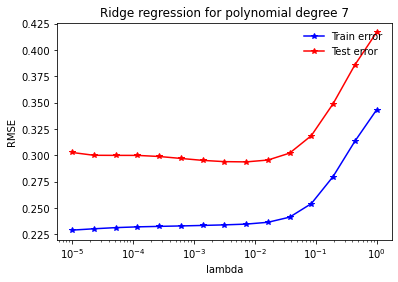

In [192]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)